# 2022-06-26 Experiments with Progressive Resizing

In [1]:
from fastai.vision.all import *
from fastcore.parallel import *

import timm
import gc

In [2]:
path = Path('paddy-disease-classification')

train_path = path / 'train_images'
train_files = get_image_files(train_path)

test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

In [3]:
train_df = pd.read_csv(path / 'train.csv')
train_df.sample(10)

,image_id,label,variety,age
3143,108258.jpg,brown_spot,ADT45,55
739,103399.jpg,bacterial_leaf_streak,Zonal,70
4149,101434.jpg,dead_heart,ADT45,70
6880,104822.jpg,hispa,AndraPonni,65
456,109375.jpg,bacterial_leaf_blight,Ponni,47
10156,109721.jpg,tungro,ADT45,70
3855,107033.jpg,brown_spot,KarnatakaPonni,75
155,108265.jpg,bacterial_leaf_blight,ADT45,55
5419,104790.jpg,downy_mildew,ADT45,60
534,105894.jpg,bacterial_leaf_streak,ADT45,60


In [4]:
def f(o): 
    size = PILImage.create(o).size
    
    if size == (640, 480):
        print(o)
    
    return PILImage.create(o).size

#sizes = parallel(f, train_files, n_workers=8)

In [5]:
#pd.Series(sizes).value_counts()

In [6]:
#train_df[train_df.image_id.isin(['100622.jpg', '103734.jpg'])]

In [7]:
#train_df[train_df.image_id.isin(['103050.jpg', '103343.jpg'])]

## Functions Inspired by fastai walkthrus

In [5]:
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

"""labels = { r.image_id: r.label for _, r in train_df.iterrows() }

def custom_labeling(p):
    out = f'no_p'
    if labels[p.name] == 'p': out = 'p'"""


def get_dls(item_tfms, batch_tfms, label=None, seed=42):
    
    labels = { r.image_id: r.label for _, r in train_df.iterrows() }
    def custom_labeling(p, label=label):
        out = f'no_{label}'
        if labels[p.name] == label: out = label
        return out
    
    if label:
        custom_labeling = custom_labeling
    else: 
        custom_labeling = parent_label
        
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        #get_y=parent_label,
        get_y=custom_labeling,
        splitter=RandomSplitter(0.2, seed=seed),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms
    )
    return dblock


def custom_fine_train(epochs, lr, arch, item_tfms, batch_tfms, seed=42, accum=False, batch_size_div=1):
    kwargs = {'bs': 64 // batch_size_div}
    
    dls = ImageDataLoaders.from_folder(
        train_path,
        seed=seed,
        valid_pct=0.2,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        **kwargs
    )
    cbs = GradientAccumulation(64) if accum else []
    
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(epochs, lr)
    
    return learn


def custom_fine_train_dls(epochs, lr, arch, dls, accum=False):

    cbs = GradientAccumulation(64) if accum else []
    
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    learn.fine_tune(epochs, lr)
    
    return learn

## Finetuning from resnet18

`nvidia-smi --query-gpu=timestamp,power.draw,memory.total,utilization.memory,temperature.gpu,clocks.current.graphics,clocks.current.sm,clocks.current.memory --loop=1 --format=csv --filename=results-resnet18-12epch.csv`

In [6]:
dls = get_dls(
    item_tfms=Resize(480, method='squish'), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    label=None,
    seed=42,
).dataloaders(train_path, bs=64)

In [7]:
train_df['validation'] = True
filter = train_df['image_id'].isin([train.name for train in dls.train.items])

train_df.loc[filter, 'validation'] = False

assert train_df[train_df.image_id.isin([valid.name for valid in dls.valid.items])].validation.all()

In [8]:
learn = custom_fine_train_dls(
    epochs=12, 
    lr=0.01, 
    arch='resnet18', 
    dls=dls, 
    accum=False
)

epoch,train_loss,valid_loss,error_rate,time
0,1.686390,1.148603,0.364729,01:33


epoch,train_loss,valid_loss,error_rate,time
0,0.988394,0.637389,0.197021,01:45
1,0.750029,0.492138,0.163383,01:32
2,0.573789,0.398358,0.123979,01:23
3,0.465427,0.316679,0.100913,01:11
4,0.346299,0.279064,0.086977,01:06
5,0.285789,0.216827,0.064392,01:07
6,0.198807,0.203080,0.060067,01:17
7,0.154914,0.166454,0.048054,01:17
8,0.125078,0.147417,0.042287,01:12
9,0.111172,0.137817,0.036040,01:10


In [9]:
learn.export('./models/2022-06-26_Experiments/resnet18_12epchs_lr01.pkl')

In [10]:
report_gpu()

#### Progressive resizing

In [11]:
dls = get_dls(
    item_tfms=Resize(480, method='squish'), 
    batch_tfms=aug_transforms(size=480, min_scale=0.75),
    label=None,
    seed=42,
).dataloaders(train_path, bs=64)

In [12]:
learn.dls = dls

In [ ]:
learn.fine_tune(16, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.469404,0.678552,0.197501,01:51


epoch,train_loss,valid_loss,error_rate,time
0,0.301744,0.317222,0.096588,02:13
1,0.242457,0.308335,0.089861,02:10
2,0.213397,0.339594,0.088900,02:08
3,0.210611,0.280693,0.082653,02:08
4,0.190447,0.317977,0.082172,02:09
5,0.175386,0.305060,0.074003,02:07
6,0.164495,0.279497,0.071120,02:08
7,0.123745,0.233367,0.059106,02:06
8,0.108638,0.219383,0.057665,02:06
9,0.071957,0.196355,0.042287,02:04


In [24]:
report_gpu()

`nvidia-smi --query-gpu=timestamp,power.draw,memory.total,utilization.memory,temperature.gpu,clocks.current.graphics,clocks.current.sm,clocks.current.memory --loop=1 --format=csv --filename=results-resnet18-12epch-size480.csv`

In [11]:
dls = get_dls(
    item_tfms=Resize(480, method='squish'), 
    batch_tfms=aug_transforms(size=480, min_scale=0.75),
    label=None,
    seed=42,
).dataloaders(train_path, bs=64)

In [26]:
learn.dls = dls

In [12]:
learn.fine_tune(12, 0.01)

NameError: name 'learn' is not defined

## 2022-096-28 resnet34

In [7]:
dls = get_dls(
    item_tfms=Resize(480, method='squish'), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    label=None,
    seed=42,
).dataloaders(train_path, bs=64)

In [8]:
learn = custom_fine_train_dls(
    epochs=12, 
    lr=0.01, 
    arch='resnet34', 
    dls=dls, 
    accum=False
)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [10]:
report_gpu()

GPU:0
no processes are running


In [9]:
torch.cuda.is_available()

True

## Base resnet50

In [11]:
learn = custom_fine_train(
    epochs=12, 
    lr=0.01, 
    arch='resnet50', 
    item_tfms=Resize(480, method='squish'), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), 
    seed=42, 
    accum=True, 
    batch_size_div=2
)

epoch,train_loss,valid_loss,error_rate,time
0,1.849958,1.347980,0.438251,01:44


epoch,train_loss,valid_loss,error_rate,time
0,1.273373,0.935615,0.308025,01:55
1,1.213359,0.885242,0.297453,01:54
2,1.116033,0.837117,0.281115,01:54
3,1.042262,0.724404,0.237386,01:54
4,0.877470,0.647780,0.217684,01:52
5,0.823194,0.550572,0.172033,01:53
6,0.733449,0.499867,0.155694,01:53
7,0.633686,0.438649,0.135031,01:52
8,0.586941,0.406005,0.126382,01:52
9,0.539635,0.385453,0.120135,01:52


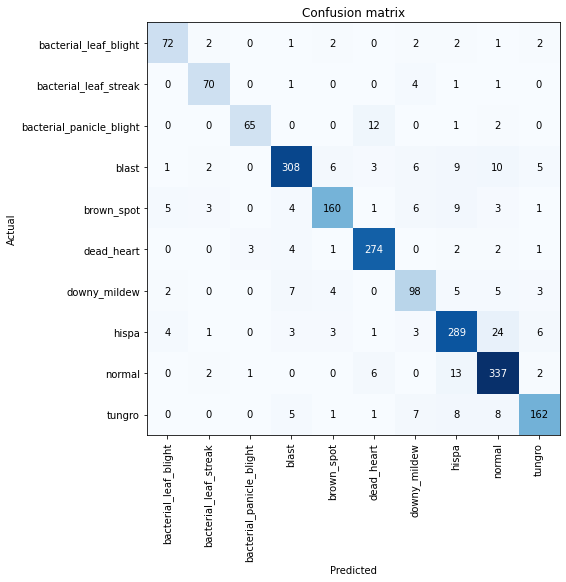

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [14]:
sample_submission = pd.read_csv(path/'sample_submission.csv')


In [15]:
test_dl = dls.test_dl(test_files)


In [16]:
preds, _ = learn.tta(dl=test_dl)
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
sample_submission['label'] = results

In [17]:
csv_file = 'subm' + '-224-resnet34-12epochs-lr01' +'_tta.csv'

sample_submission.to_csv(csv_file, index=False)

!head {csv_file}

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
